In [1]:
%matplotlib inline

import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
#import statsmodels.api as sm  
import seaborn as sns 
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

# Import statsmodel
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
#sns.set_style('darkgrid')
plt.style.use('ggplot')
np.set_printoptions(precision=3, suppress=True)

In [85]:
import os
os.getcwd()
path = "forestfires.csv"
data = pd.read_csv(path)

In [86]:
data.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Goal :Fit a suitable linear regression model that explains the burned area of the forest fires

##### FEATURES

###### The aim is to understand how the burned area of forest fires, in the northeast region of Portugal, is related to the meteorological and other data. And below gives some details of the variables considered in this study.

### Spatial Information
X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9

### Temporal Information
month - month of the year: "jan" to "dec"
day - day of the week: "mon" to "sun"

### Forest Fire Weather Index
FFMC - FFMC index from the FWI system: 18.7 to 96.20
DMC - DMC index from the FWI system: 1.1 to 291.3
DC - DC index from the FWI system: 7.9 to 860.6
ISI - ISI index from the FWI system: 0.0 to 56.10

### Meteorological Information
temp - temperature in Celsius degrees: 2.2 to 33.30
RH - relative humidity in %: 15.0 to 100
wind - wind speed in km/h: 0.40 to 9.40
rain - outside rain in mm/m2 : 0.0 to 6.4


### RESPONSE
area - the burned area of the forest (in ha): 0.00 to 1090.84



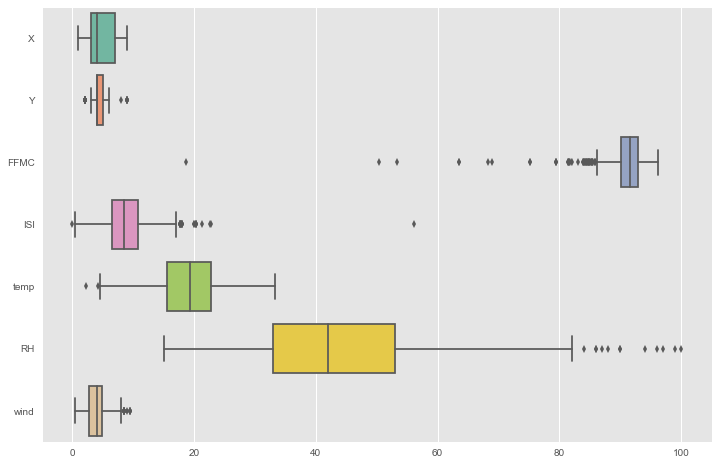

In [87]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=data[['X','Y','FFMC','ISI','temp','RH','wind']], orient="h", palette="Set2")

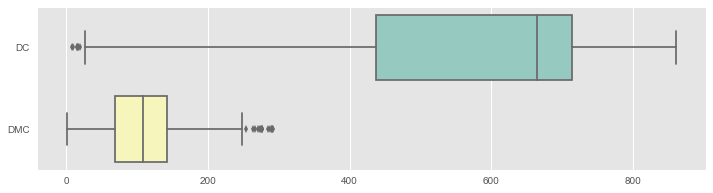

In [88]:
plt.figure(figsize=(12, 3))
ax = sns.boxplot(data=data[['DC','DMC']], orient="h", palette="Set3")

#### Early Insights

•Only 8 observations have data for rain and rest all are zero. Most importantly there are 2 observations where there is Burned Area in the presence of rain which needs to be analyzed. We will ignore this feature from regression. 
•The features "DMC", "RH", "ISI", "FFMC" have outlier observations. The decision to include or discard these out lier observations must be completely based on the domain knowledge. 


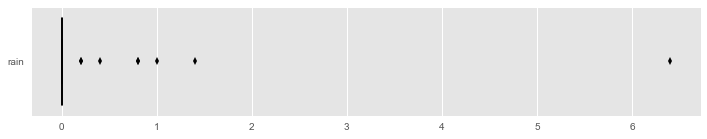

In [89]:
plt.figure(figsize=(12, 2))
ax = sns.boxplot(data=data[['rain']], orient="h", color="black")

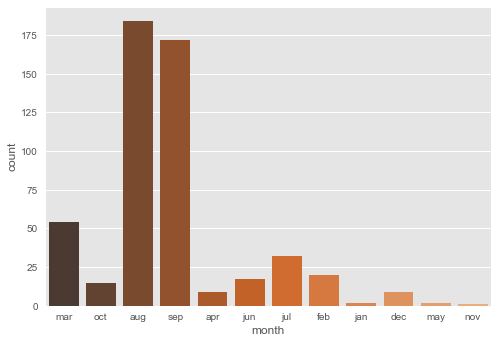

In [90]:
sns.countplot(x="month", data=data, palette="Oranges_d");

##### Inference 
Months August,september have more count, but we cant go by this count , because most of our burned area is zero , so we should first check our area , dependent variable

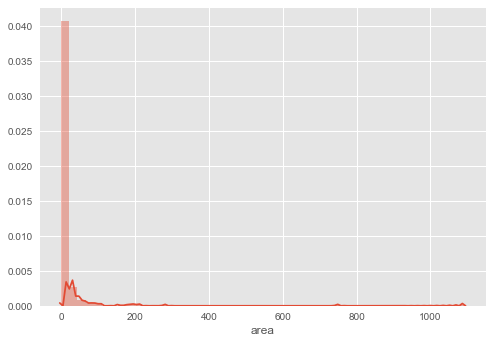

In [91]:
sns.distplot(data['area']);

##### Inference:
We can see here most of the values are for burned area is zero so let us have a look at non zero values distribution.

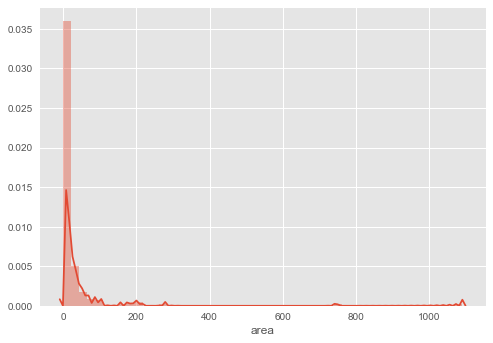

In [92]:
sns.distplot(data['area'][data['area']>0]);

#### Inference

We can see long right skewed distribution of dependent or response variable , one way to deal with the skewness is to take a log transformation. Log transformation converts skewed distribution to approximatley normal distribution

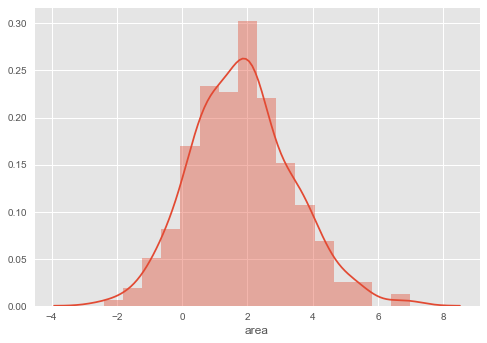

In [93]:
import numpy as np
sns.distplot(np.log(data['area'][data['area']>0]));

#### Inference 

Now we can see from the above graph that the log of transformation where values are greater than zero is forming a normal distribution. The next step is to consider only values where burned area is greater than zero and try to see the relationship between various independent variables.

In [97]:
#Creating a subset of data for area>0
data_PositiveBurntArea=data[data['area']>0]
data_PositiveBurntArea.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61


##### Observation
Removing rain attribute because it has barely any information present

In [98]:
data_PositiveBurntArea['logArea']=np.log(data_PositiveBurntArea['area'])
data_PositiveBurntArea=data_PositiveBurntArea.drop('rain',axis=1)
data_PositiveBurntArea = data_PositiveBurntArea.reset_index(drop=True)
data_PositiveBurntArea.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,area,logArea
0,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.36,-1.021651
1,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.43,-0.843970
2,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.47,-0.755023
3,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.55,-0.597837
4,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.61,-0.494296


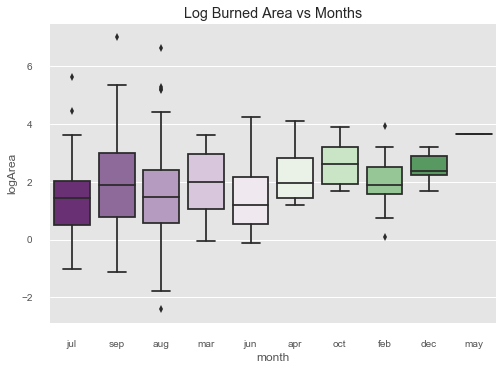

In [99]:
sns.boxplot(x="month", y="logArea", data=data_PositiveBurntArea, palette="PRGn",).set_title("Log Burned Area vs Months")
sns.despine(offset=10, trim=True)

#### Inference
Since months are not giving much insights from the plot lets consider seasons from the data and plot with respect to logArea

In [100]:
#Defining a function which would convert the months into seasons
def Seasons(inputString):
    if (inputString == 'feb' or inputString == 'jan' or inputString == 'dec'):
        row['Season'] = 'Winter'
    elif (inputString == 'oct' or inputString == 'nov' or inputString == 'sep'):
        row['Season'] = 'Autumn'
    elif (inputString == 'aug' or inputString == 'jul' or inputString == 'jun'):
        row['Season'] = 'Summer'
    else:
        row['Season'] = 'Spring'
    return row

In [101]:
Sea = []
for index, row in data_PositiveBurntArea.iterrows():
    Sea.append(Seasons(row['month']))
data_burned_Seasons = pd.DataFrame(Sea)
data_burned_Seasons.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,area,logArea,Season
0,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.36,-1.021651,Summer
1,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.43,-0.843970,Autumn
2,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.47,-0.755023,Autumn
3,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.55,-0.597837,Summer
4,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.61,-0.494296,Summer


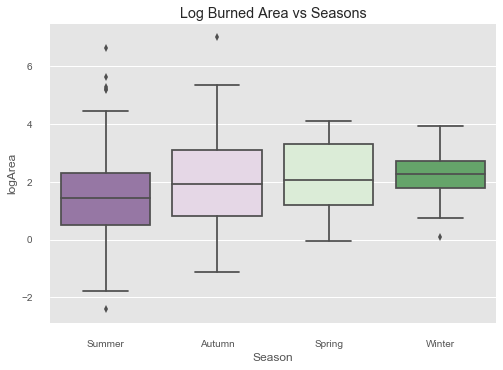

In [102]:
sns.boxplot(x="Season", y="logArea", data=data_burned_Seasons, palette="PRGn",).set_title("Log Burned Area vs Seasons")
sns.despine(offset=10, trim=True)

#### Inference : 
We can see that forest burned area is relatively low during the summer seasons ,as an initial thought this may be attributed towards higher humidity in summer resulting in high moisture which would not facilitate forest fires spread. Now lets see day wise forest fires.


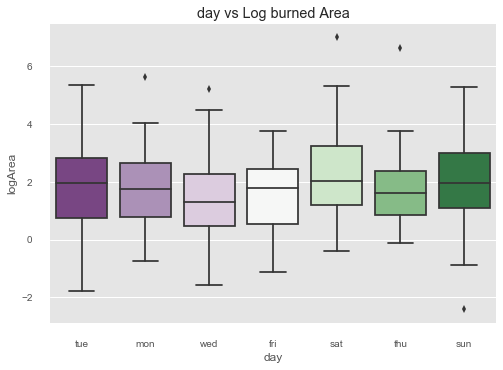

In [103]:
sns.boxplot(x="day", y="logArea", data=data_burned_Seasons, palette="PRGn",).set_title("day vs Log burned Area")
sns.despine(offset=10, trim=True)

#### Inference :
Saturday seems to be the popular day for forest fires , can be attributed to factors like human activities during the weekends. As a next step lets correlation matrix to get more info on rest of the variables in the data set with logArea

In [104]:
corr = data_burned_Seasons.corr()
cmap = cmap=sns.diverging_palette(11, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("CORELATION MATRIX")\
    .set_precision(2)\
    .set_table_styles(magnify())

#### Inference from correlations
From the correlation matrix we can figure out that there is no high positive or negative correlation among the variables
1)FFMC and ISI are the only measures which are showing high correlation other variables dont show much considerable correlation hence we dont expect any multicollinearity in this case.

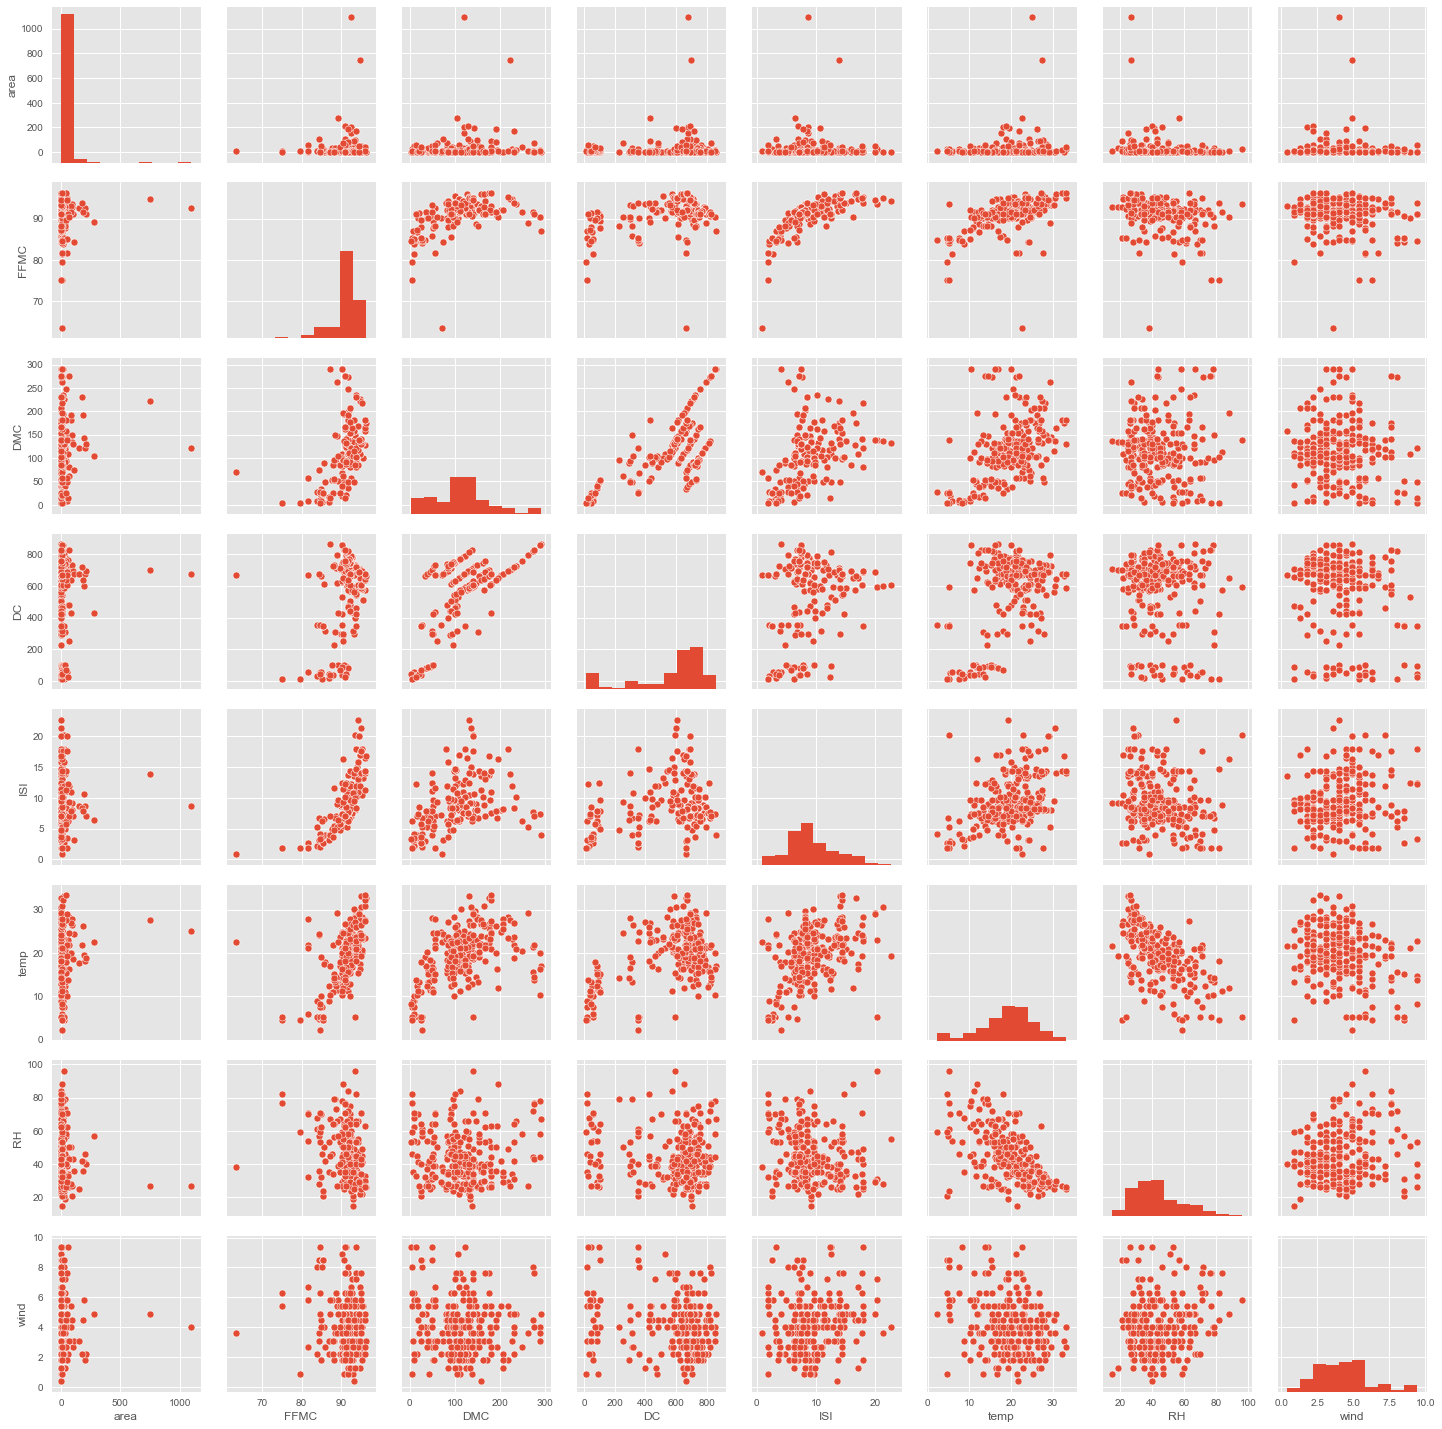

In [105]:
pair = sns.pairplot(data_burned_Seasons.dropna(),vars=["area","FFMC","DMC","DC","ISI","temp","RH","wind"])

### Variable Selection :

From the below consideration , there doesn't seem to be any linear relation with response variable here , so we are left with only day and seasons as our important measures for fitting the model

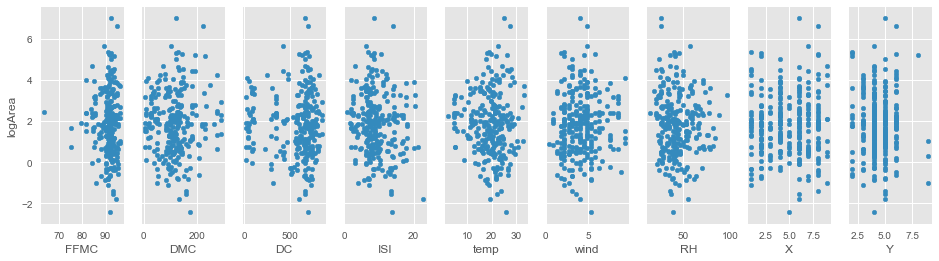

In [108]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 9, sharey=True)
data_burned_Seasons.plot(kind='scatter', x='FFMC', y='logArea', ax=axs[0], figsize=(16, 4))
data_burned_Seasons.plot(kind='scatter', x='DMC', y='logArea', ax=axs[1])
data_burned_Seasons.plot(kind='scatter', x='DC', y='logArea', ax=axs[2])
data_burned_Seasons.plot(kind='scatter', x='ISI', y='logArea', ax=axs[3])
data_burned_Seasons.plot(kind='scatter', x='temp', y='logArea', ax=axs[4])
data_burned_Seasons.plot(kind='scatter', x='wind', y='logArea', ax=axs[5])
data_burned_Seasons.plot(kind='scatter', x='RH', y='logArea', ax=axs[6])
data_burned_Seasons.plot(kind='scatter', x='X', y='logArea', ax=axs[7])
data_burned_Seasons.plot(kind='scatter', x='Y', y='logArea', ax=axs[8])

#### Validating the intuition
We know from the graphs above that there is no linear association between our response and variables shown. Let us fit this variables into regression model and validate our intuition


In [111]:
import statsmodels.formula.api as smf
SimpleModel = smf.ols(formula='logArea ~ Season + day + FFMC + DMC + DC + ISI + temp + RH + wind+X+Y', data=data_burned_Seasons).fit()
SimpleModel.params
SimpleModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logArea   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.419
Date:                Sat, 08 Apr 2017   Prob (F-statistic):              0.123
Time:                        18:45:50   Log-Likelihood:                -483.77
No. Observations:                 270   AIC:                             1006.
Df Residuals:                     251   BIC:                             1074.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            0.8147      4.044      0.201      0.840        -7.149     8.779
Season[T.Spring]    -0.4383      0.815     -0.538      0.591        -2.044     1.167
Season[T.Summer]    -0.8908      0.312     -2.853      0.005        -1.506    -0.276
Season[T.Winter]     0.0779      0.811      0.096      0.924        -1.519     1.675
day[T.mon]           0.1198      0.349      0.343      0.732        -0.567     0.807
day[T.sat]           0.6521      0.337      1.937      0.054        -0.011     1.315
day[T.sun]           0.4239      0.332      1.275      0.203        -0.231     1.079
day[T.thu]           0.2030      0.370      0.548      0.584        -0.526     0.932
day[T.tue]           0.3736      0.348      1.075      0.284        -0.311     1.058
day[T.wed]           0.0706      0.367      0.192      0.848        -0.653     0.794
FFMC                 0.0134      0.043      0.316      0.752        -0.070     0.097
DMC                  0.0062      0.003      2.401      0.017         0.001     0.011
DC                  -0.0015      0.001     -1.302      0.194        -0.004     0.001
ISI                 -0.0291      0.036     -0.805      0.422        -0.100     0.042
temp                 0.0199      0.032      0.616      0.538        -0.044     0.083
RH                  -0.0055      0.009     -0.585      0.559        -0.024     0.013
wind                 0.0706      0.057      1.246      0.214        -0.041     0.182
X                    0.0359      0.046      0.782      0.435        -0.055     0.126
Y                   -0.0453      0.093     -0.485      0.628        -0.229     0.138
==============================================================================
Omnibus:                        3.377   Durbin-Watson:                   1.023
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.086
Skew:                           0.252   Prob(JB):                        0.214
Kurtosis:                       3.140   Cond. No.                     2.82e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression Diagonostics 

Validating the individual regressors fitted values vs residuals , There appears random scatter almost all variables

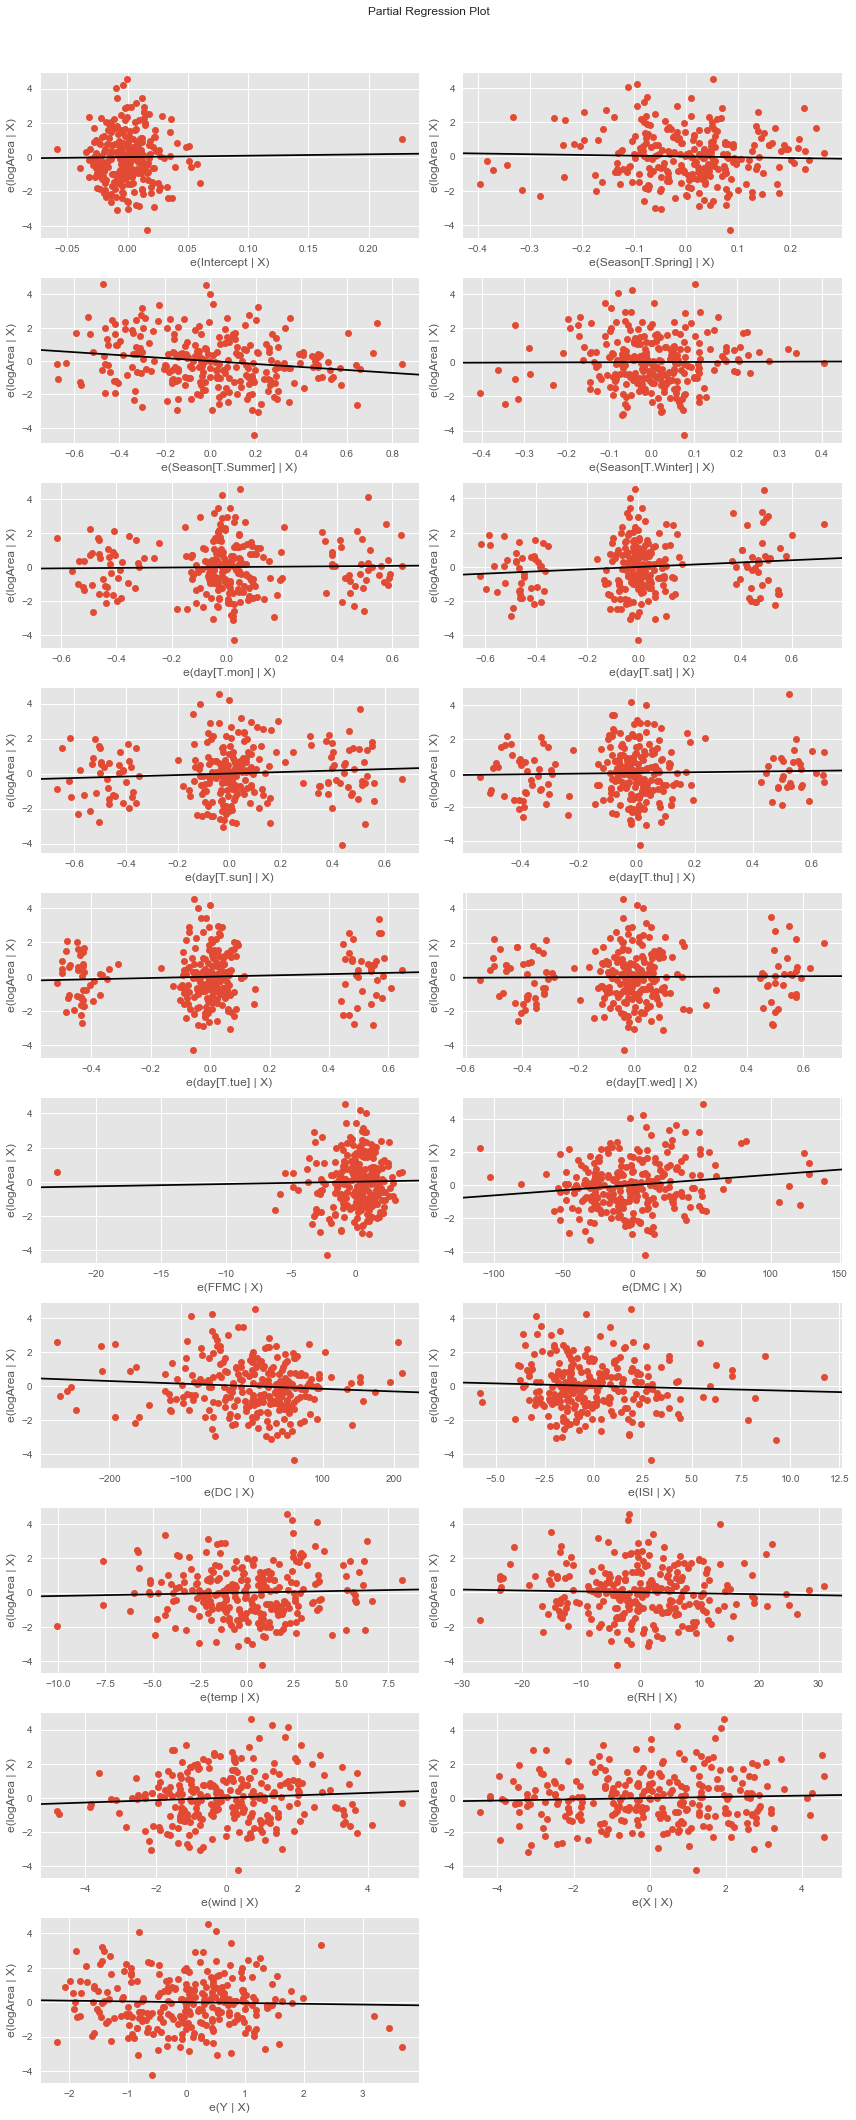

In [121]:

fig = plt.figure(figsize=(12,30))
fig = sm.graphics.plot_partregress_grid(SimpleModel, fig=fig)

In [114]:
import statsmodels.formula.api as smf
SimpleModel1 = smf.ols(formula='logArea ~ Season + day + ISI + DC + temp  +X+Y', data=data_burned_Seasons).fit()
SimpleModel1.params
SimpleModel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logArea   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.225
Date:                Sat, 08 Apr 2017   Prob (F-statistic):              0.257
Time:                        19:59:54   Log-Likelihood:                -488.07
No. Observations:                 270   AIC:                             1006.
Df Residuals:                     255   BIC:                             1060.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            1.0183      0.920      1.107      0.269        -0.794     2.830
Season[T.Spring]     0.4843      0.732      0.662      0.509        -0.956     1.925
Season[T.Summer]    -0.5074      0.270     -1.879      0.061        -1.039     0.024
Season[T.Winter]     0.7758      0.716      1.083      0.280        -0.635     2.186
day[T.mon]           0.0583      0.347      0.168      0.867        -0.625     0.742
day[T.sat]           0.6423      0.337      1.907      0.058        -0.021     1.306
day[T.sun]           0.4065      0.333      1.220      0.224        -0.250     1.063
day[T.thu]           0.1652      0.365      0.453      0.651        -0.553     0.884
day[T.tue]           0.3144      0.348      0.904      0.367        -0.371     1.000
day[T.wed]          -0.0416      0.364     -0.114      0.909        -0.757     0.674
ISI                 -0.0144      0.028     -0.510      0.610        -0.070     0.041
DC                   0.0004      0.001      0.405      0.686        -0.001     0.002
temp                 0.0325      0.023      1.409      0.160        -0.013     0.078
X                    0.0309      0.046      0.670      0.504        -0.060     0.122
Y                   -0.0307      0.094     -0.328      0.743        -0.215     0.154
==============================================================================
Omnibus:                        6.269   Durbin-Watson:                   0.997
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.014
Skew:                           0.326   Prob(JB):                       0.0495
Kurtosis:                       3.331   Cond. No.                     8.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

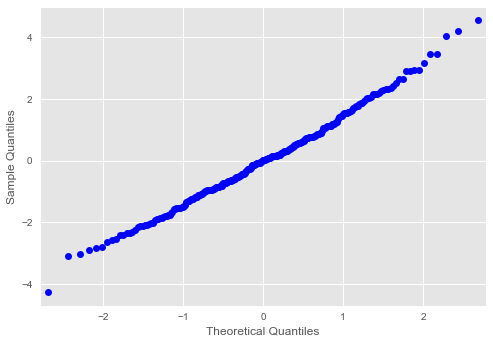

In [122]:
import statsmodels.api as sm
probplot = sm.ProbPlot(SimpleModel.resid)
probplot.qqplot()
plt.show()

##### influential observations detection
There are no much influential observations from the plot below , hence no need to remove any data from the data set. 

<Container object of 3 artists>

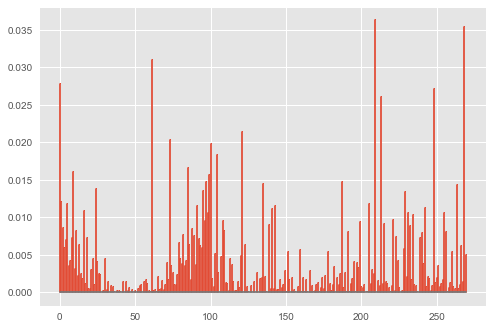

In [123]:

influence = SimpleModel.get_influence()
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")

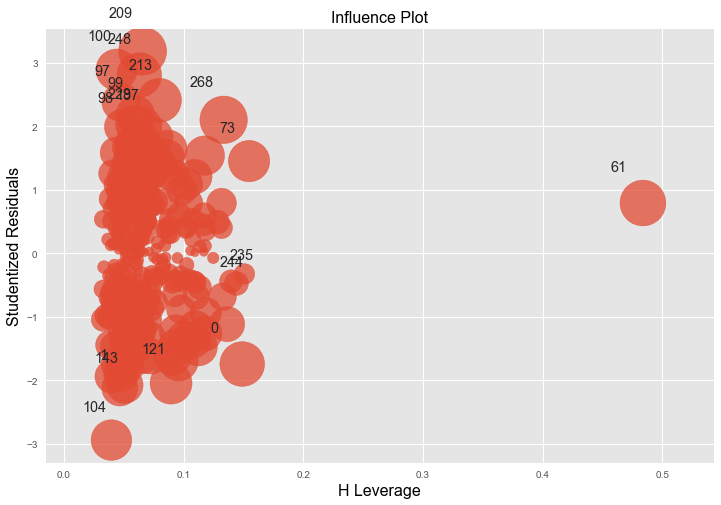

In [124]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(SimpleModel, ax=ax, criterion="cooks")

In [140]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices(formula_like='logArea ~ Season + day + FFMC + DMC + DC + ISI + temp + RH + wind+X+Y', data=data_burned_Seasons, return_type="dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
([print(x,v) for x,v in  zip(X.columns,vif)])

Intercept 1947.18886582
Season[T.Spring] 6.40820402904
Season[T.Summer] 2.88644805718
Season[T.Winter] 5.12364104667
day[T.mon] 1.79116243229
day[T.sat] 1.77185126243
day[T.sun] 1.8914981479
day[T.thu] 1.65957310843
day[T.tue] 1.6630075474
day[T.wed] 1.67985251644
FFMC 2.95017972612
DMC 3.02168157007
DC 8.73955313349
ISI 2.66774069236
temp 4.69923543424
RH 2.34748087372
wind 1.35296175396
X 1.42136160174
Y 1.41437482157


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

##### VIF interpretation
One recommendation is that if VIF is greater than 5, then the explanatory variable given is highly collinear with the other explanatory variables. So going by the thumb rule lets remove DC from the set and run the model again

In [141]:
import statsmodels.formula.api as smf
SimpleModel1 = smf.ols(formula='logArea ~ Season + day + FFMC + DMC  + ISI + temp + RH + wind+X+Y', data=data_burned_Seasons).fit()
SimpleModel1.params
SimpleModel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logArea   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.399
Date:                Sat, 08 Apr 2017   Prob (F-statistic):              0.137
Time:                        21:17:31   Log-Likelihood:                -484.68
No. Observations:                 270   AIC:                             1005.
Df Residuals:                     252   BIC:                             1070.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.4539      3.930     -0.115      0.908        -8.193     7.286
Season[T.Spring]     0.4596      0.435      1.057      0.292        -0.397     1.316
Season[T.Summer]    -0.6359      0.243     -2.612      0.010        -1.115    -0.156
Season[T.Winter]     0.8114      0.584      1.389      0.166        -0.339     1.962
day[T.mon]           0.1140      0.349      0.326      0.744        -0.574     0.802
day[T.sat]           0.6598      0.337      1.958      0.051        -0.004     1.323
day[T.sun]           0.4164      0.333      1.251      0.212        -0.239     1.072
day[T.thu]           0.2056      0.371      0.554      0.580        -0.525     0.936
day[T.tue]           0.3776      0.348      1.085      0.279        -0.308     1.063
day[T.wed]           0.0539      0.368      0.147      0.884        -0.670     0.778
FFMC                 0.0156      0.043      0.367      0.714        -0.068     0.099
DMC                  0.0042      0.002      2.018      0.045         0.000     0.008
ISI                 -0.0320      0.036     -0.885      0.377        -0.103     0.039
temp                 0.0262      0.032      0.824      0.411        -0.037     0.089
RH                  -0.0032      0.009     -0.349      0.727        -0.021     0.015
wind                 0.0639      0.057      1.131      0.259        -0.047     0.175
X                    0.0403      0.046      0.878      0.381        -0.050     0.131
Y                   -0.0490      0.093     -0.525      0.600        -0.233     0.135
==============================================================================
Omnibus:                        4.414   Durbin-Watson:                   1.005
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                4.081
Skew:                           0.281   Prob(JB):                        0.130
Kurtosis:                       3.219   Cond. No.                     6.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Congregating all the index measures and forming the model
The above R squared doesnot imply that it is a bad model however the index values are all related to Fire Weather index of which FFMC(moisture content in wastes) DC and DMC( denote moisture content in upper layers of vegetation) and Initial spread Index(ISI) is closely related with FFMC so combining this values and running the model


In [146]:
import statsmodels.formula.api as smf
SimpleModel2 = smf.ols(formula='logArea ~Season + day + (FFMC + DMC + DC + ISI)**2 + temp + RH + wind+X+Y', data=data_burned_Seasons).fit()
SimpleModel2.params
SimpleModel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logArea   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1.676
Date:                Sat, 08 Apr 2017   Prob (F-statistic):             0.0281
Time:                        21:28:16   Log-Likelihood:                -476.33
No. Observations:                 270   AIC:                             1003.
Df Residuals:                     245   BIC:                             1093.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            2.5635      8.759      0.293      0.770       -14.690    19.817
Season[T.Spring]    -0.2963      0.934     -0.317      0.751        -2.135     1.543
Season[T.Summer]    -1.3797      0.345     -4.004      0.000        -2.058    -0.701
Season[T.Winter]     0.2909      1.006      0.289      0.773        -1.691     2.273
day[T.mon]          -0.0334      0.350     -0.095      0.924        -0.723     0.656
day[T.sat]           0.6255      0.333      1.879      0.061        -0.030     1.281
day[T.sun]           0.3939      0.328      1.201      0.231        -0.252     1.040
day[T.thu]           0.1238      0.374      0.331      0.741        -0.612     0.860
day[T.tue]           0.2512      0.352      0.713      0.477        -0.443     0.945
day[T.wed]           0.0487      0.367      0.133      0.894        -0.674     0.772
FFMC                -0.0144      0.105     -0.137      0.891        -0.222     0.193
DMC                 -0.1472      0.115     -1.283      0.201        -0.373     0.079
DC                   0.0236      0.020      1.191      0.235        -0.015     0.063
ISI                 -0.3867      0.941     -0.411      0.682        -2.241     1.467
FFMC:DMC             0.0019      0.001      1.509      0.133        -0.001     0.004
FFMC:DC             -0.0003      0.000     -1.074      0.284        -0.001     0.000
FFMC:ISI             0.0044      0.010      0.438      0.662        -0.015     0.024
DMC:DC           -2.772e-05   1.41e-05     -1.962      0.051     -5.56e-05  1.09e-07
DMC:ISI          -4.317e-05      0.001     -0.051      0.959        -0.002     0.002
DC:ISI              -0.0001      0.000     -0.457      0.648        -0.001     0.000
temp                -0.0016      0.034     -0.047      0.963        -0.068     0.065
RH                  -0.0029      0.009     -0.305      0.761        -0.021     0.016
wind                 0.0530      0.058      0.912      0.363        -0.062     0.168
X                    0.0543      0.046      1.186      0.237        -0.036     0.144
Y                   -0.0857      0.094     -0.916      0.361        -0.270     0.099
==============================================================================
Omnibus:                        3.304   Durbin-Watson:                   1.095
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.009
Skew:                           0.248   Prob(JB):                        0.222
Kurtosis:                       3.144   Cond. No.                     1.03e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+07. This might indicate that there are
strong multicollinearity or other numerical pr

### Conclusion

We arrive at the optimal model by succesive runs and validation rules and regression diagnostics.
This does not necessarily mean that we have bad model , but with the given information we can arrive at this particular
optimal model. The further steps of improvement may  include other relevant variables which may be collected to have
better prediction model. Through this model the business solution is to create an alarming system whenever there is potential risk of a fire. This would reduce the cost of existing system of sensors and camera installations at particular places to detect forest fires. We can use geospatial information from satellite with the FWI indexes at paricular area along with day specific and season specific attributes which contribute towards forest fires.